In [1]:
import pandas as pd
from sgp4.api import WGS72OLD, WGS72, WGS84, Satrec
import numpy as np
import pytz
from datetime import timedelta, datetime
from sgp4 import omm

In [2]:
constellation = []
with open('constellations/gps.csv') as f:
    for fields in omm.parse_csv(f):
        sat = Satrec()
        omm.initialize(sat, fields)
        constellation.append(sat)

# Orbit synthesization parameters
sample_rate = 0.01
start_date = datetime(2022, 9, 22, 7)
duration = (24 * 60 * 60) / ((constellation[0].no_kozai * 720) / np.pi)

In [3]:
from pymap3d.ecef import eci2geodetic
from datetime import datetime
from functools import partial

def gen_orbit(orbit: Satrec, sample_rate_hz, start_date):
    """ Generates a pandas Dataframe with eci coordinates and datetime
    
    orbit: A Satrec object
    """
    dt_s = 1/sample_rate_hz
    us_dt = int((1/sample_rate_hz) * 1e6) # Conversion in microseconds
    dt = timedelta(microseconds=us_dt)
    date = start_date
    data_map = {
            "r_eci"     : [],
            "v_eci"     : [],
            "datetime"  : []
            }
    for i in range(int(duration * sample_rate_hz) + 1):
        julian_date = pd.Timestamp(date).to_julian_date()
        jd, fr = int(julian_date), julian_date % 1
        # For now, no SGP4_ERROR handling
        _, r, v = orbit.sgp4(jd, fr)
        data_map["r_eci"].append(np.array(r) * 10**3) # Conversion from km to m
        data_map["v_eci"].append(np.array(v) * 10**3) # Conversion from km to m
        data_map["datetime"].append(date.replace(tzinfo=pytz.UTC))
        date = date + dt
    return pd.DataFrame(data_map)

def to_geodetic(i, coordinate_array, time_array = None):
    """ Uses pymap library to generate geodetic coordinates
    """
    if time_array is None:
        time = datetime.now()
    else:
        time = time_array[i]
    lat, long, altitude = eci2geodetic(*(coordinate_array[i] * 1000), time)
    return lat, long

def df_to_geodetic(orbit_df, fixed_earth=False):
    """ Converts the upper pandas eci dataframe to a geodetic coordinate array
    """
    if(fixed_earth):
        time_array = None
    else:
        time_array = orbit_df["datetime"]
    cords = list(map(
                    partial(to_geodetic,
                            coordinate_array=orbit_df["r_eci"],
                            time_array=time_array),
                    range(len(orbit_df))
                ))
    return cords
    

In [46]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = [key for key in mcolors.BASE_COLORS]

def visualize_cords(points, show=True, ax=None, color="blue"):
    if(ax is None):
        ax = plt.axes(projection=ccrs.PlateCarree())
        #ax.stock_img()
        ax.set_extent((-180, 180, -90, 90))
        ax.coastlines()
    
    latitude, longitude = [], []
    for p in points:
        if(len(latitude) > 0):
            lat_diff = np.abs(p[1] - latitude[-1])
            if(lat_diff >= 300):
                plt.plot(latitude, longitude,
                 color=color, linestyle=':',
                 transform=ccrs.PlateCarree(),
                 )
                latitude, longitude = [], []
        longitude.append(p[0])
        latitude.append(p[1])
    if(len(latitude) > 0):
        plt.plot(latitude, longitude,
         color=color, linestyle=':',
         transform=ccrs.PlateCarree(),
         )

    if(show):
        plt.show()

def visualize_orbits(orbits, clusters=None, save=False):
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.stock_img()
    ax.set_extent((-180, 180, -90, 90))
    ax.coastlines()
    
    for i in range(len(orbits)):
        if(clusters is not None):
            color = colors[clusters[i] % len(colors)]
        else:
            color = "blue"
        visualize_cords(orbits[i], show=False, ax=ax, color=color)
    
    circle = plt.Circle((-10, 10), 10, fill = False, color="r")
    ax.add_artist(circle)
    
    plt.savefig("orbits.pdf", format="pdf", bbox_inches="tight")
    
    plt.show()

In [47]:
orbits = [df_to_geodetic(gen_orbit(
            orbit,
            sample_rate,
            start_date
            )) for orbit in constellation]

In [48]:
forest1_tle1 = "1 51036U 22002BE  22201.75487768  .00007975  00000-0  43604-3 0  9998"
forest1_tle2 = "2 51036  97.4864 268.2714 0007936 329.9259  30.1516 15.14521714 28455"
start_date = datetime(2022, 7, 4, 11, 7)
sample_rate = 0.01
duration = (24 * 60 * 60) / ((forest1_satrec.no_kozai * 720) / np.pi)

forest1_satrec = Satrec.twoline2rv(forest1_tle1, forest1_tle2)

orbits = [df_to_geodetic(gen_orbit(
            orbit,
            sample_rate,
            start_date
            )) for orbit in [forest1_satrec]]

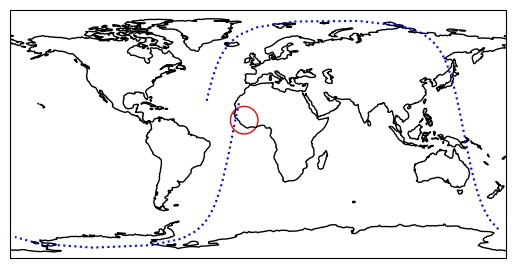

In [49]:
visualize_orbits(orbits)

In [58]:
mcolors.BASE_COLORS

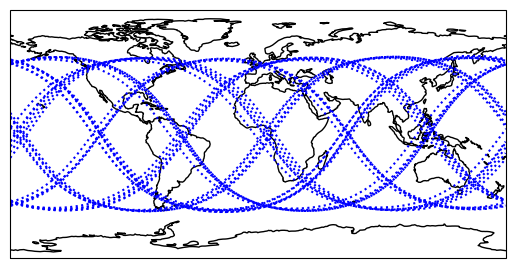

In [59]:
visualize_orbits(orbits_fixed)

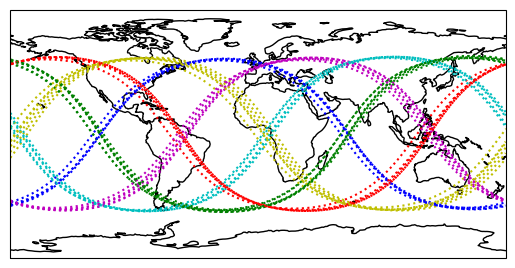

In [60]:
from scipy.cluster.vq import whiten, kmeans, vq, kmeans2

def visualize_orbitclusters(orbits, constellation, k=6):
    data = np.array([(np.degrees(orbit.inclo), np.degrees(orbit.nodeo))
                        for orbit in constellation])

    data_std = data.std(axis=0)
    data_mean = data.std(axis=0)
    data_norm = (data-data_mean) / data_std
    data_norm = data

    # assign centroids and clusters
    centroids, clusters = kmeans(data_norm, k)
    clusters, distances = vq(data_norm, centroids)
    visualize_orbits(orbits, clusters=clusters)

visualize_orbitclusters(orbits_fixed, constellation, k=6)

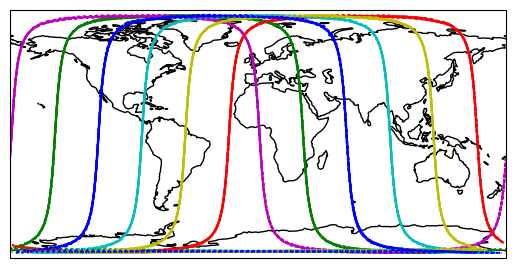

In [61]:
constellation = []
with open('constellations/iridium.csv') as f:
    for fields in omm.parse_csv(f):
        sat = Satrec()
        omm.initialize(sat, fields)
        constellation.append(sat)

# Orbit synthesization parameters
sample_rate = 0.01
start_date = datetime(2022, 9, 22, 7)
duration = (24 * 60 * 60) / ((constellation[0].no_kozai * 720) / np.pi)
orbits_fixed = [df_to_geodetic(gen_orbit(
            orbit,
            sample_rate,
            start_date
            ), fixed_earth=True) for orbit in constellation]

visualize_orbitclusters(orbits_fixed, constellation, k=6)

In [67]:
constellation = []
with open('constellations/oneweb.csv') as f:
    for fields in omm.parse_csv(f):
        sat = Satrec()
        omm.initialize(sat, fields)
        constellation.append(sat)

# Orbit synthesization parameters
sample_rate = 0.01
start_date = datetime(2022, 9, 22, 7)
duration = (24 * 60 * 60) / ((constellation[0].no_kozai * 720) / np.pi)
orbits_fixed = [df_to_geodetic(gen_orbit(
            orbit,
            sample_rate,
            start_date
            ), fixed_earth=False) for orbit in constellation]

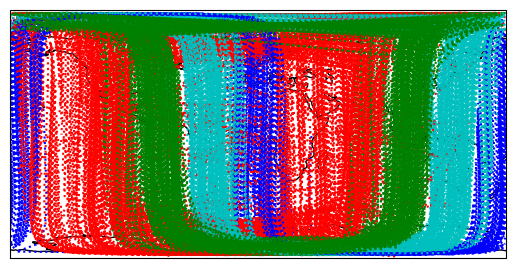

In [68]:
visualize_orbitclusters(orbits_fixed, constellation, k=4)

# TODO: try to make the lines transparent, so it's an area

In [5]:
constellation = []
with open('constellations/starlink.csv') as f:
    for fields in omm.parse_csv(f):
        sat = Satrec()
        omm.initialize(sat, fields)
        constellation.append(sat)

# Orbit synthesization parameters
sample_rate = 0.01
start_date = datetime(2022, 9, 22, 7)
duration = (24 * 60 * 60) / ((constellation[0].no_kozai * 720) / np.pi)
orbits_fixed = [df_to_geodetic(gen_orbit(
            orbit,
            sample_rate,
            start_date
            ), fixed_earth=False) for orbit in constellation]

In [ ]:
# TODO: try incorporating height information